In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Calculate limb darkening coefficients

First... some imports!

In [31]:
from ExoCTK import modelgrid
from svo_filters import svo
from ExoCTK.limb_darkening import limb_darkening_fit as lf
import astropy.units as q
import matplotlib.pyplot as plt

To calculate the limb darkening coefficients, we need a model grid. 

I'm going to use the Phoenix ACES models for this example but any grid can be loaded into a `core.ModelGrid()` object if the spectra are stored as FITS files.

We will pass a directory or directory+wildcard path to the initialize the model grid.

We can also use the `resolution` argument to resample the model spectra. This greatly speeds up the caluclations.

In [32]:
fits_files = '/user/jfilippazzo/Models/ACES/default/'
model_grid = modelgrid.ModelGrid(fits_files, resolution=700)
print(model_grid.data)

1056 models loaded from /user/jfilippazzo/Models/ACES/default/
 Teff  logg ...                          filename                         
------ ---- ... ----------------------------------------------------------
6500.0  6.0 ... lte06500-6.00+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4200.0  4.5 ... lte04200-4.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
6200.0  3.5 ... lte06200-3.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4700.0  3.5 ... lte04700-3.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
6900.0  6.0 ... lte06900-6.00-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
3800.0  5.0 ... lte03800-5.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
3500.0  3.0 ... lte03500-3.00-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2700.0  5.5 ... lte02700-5.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
3800.0  5.5 ... lte03800-5.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4800.0  4.5 ... lte04800-4.50+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
   ...  ... ...                      

Now let's customize it to our desired effective temperature, surface gravity, metallicity, and wavelength ranges by running the `customize()` method on our grid.

In [49]:
model_grid.customize(Teff_rng=(2500,2600), logg_rng=(5,5.5), FeH_rng=(-0.5,0.5))#, wave_rng=(0.9,1.9))

12/12 spectra in parameter range Teff:  (2500, 2600) , logg:  (5, 5.5) , FeH:  (-0.5, 0.5) , wavelength:  (0, 40)
Loading flux into table...
100.00 percent complete!


In [59]:
trap1 = model_grid.get(teff, logg, FeH)

Interpolating grid point [2511/5.22/0.04]...
Run time in seconds:  12.4670729637146


Now we can caluclate the limb darkening coefficients using the `ldcfit.ldc()` function.

We just need to specify the desired effective temperature, surface gravity, metallicity, and the function(s) to fit to the limb darkening profile (including 'uniform', 'linear', 'quadratic', 'square-root', 'logarithmic', 'exponential', and 'nonlinear').

We can do this with for a single model on the grid...

quadratic :
wavelength   c1    e1    c2    e2 
---------- ----- ----- ----- -----
      0.05 0.220 0.025 0.410 0.034

4-parameter :
wavelength   c1    e1    c2     e2    c3     e3    c4    e4 
---------- ----- ----- ------ ----- ------ ----- ----- -----
      0.05 1.104 0.002 -0.249 0.004 -0.006 0.004 0.021 0.002



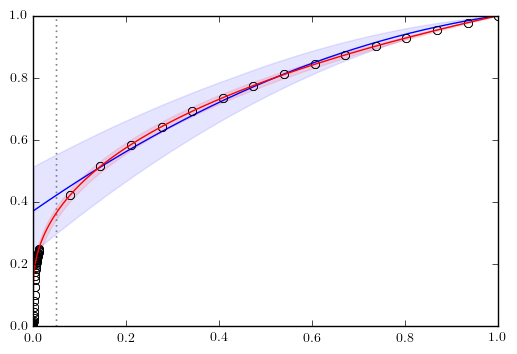

In [51]:
teff, logg, FeH = 2500, 5, 0
on_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], plot=plt.figure())

...or a single model off the grid, where the spectral intensity model is directly interpolated before the limb darkening coefficients are calculated. This takes a minute...

quadratic :
wavelength   c1    e1    c2    e2 
---------- ----- ----- ----- -----
       1.1 0.225 0.025 0.417 0.034

4-parameter :
wavelength   c1    e1    c2     e2    c3     e3    c4    e4 
---------- ----- ----- ------ ----- ------ ----- ----- -----
       1.1 1.088 0.003 -0.187 0.007 -0.060 0.007 0.038 0.003



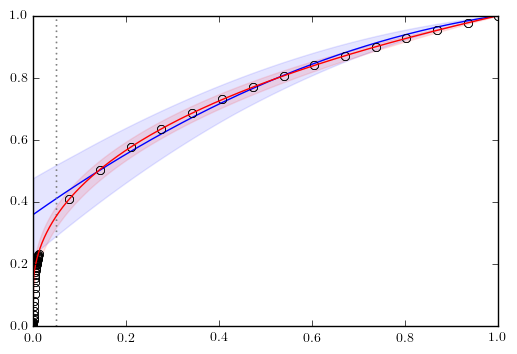

In [52]:
teff, logg, FeH = 2511, 5.22, 0.04
off_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], grid_point=trap1, plot=plt.figure())

## Using a Photometric Bandpass

Above we caluclated the limb darkening in a particular wavelength range set when we ran the `customize()` method on our `core.ModelGrid()` object. 

Additionally, we can calculate the limb darkening through a particular photometric bandpass.

First we have to create a `core.Filter()` object which we can then pass to the functions in the `ldcfit` module. Let's use 2MASS H-band for this example.

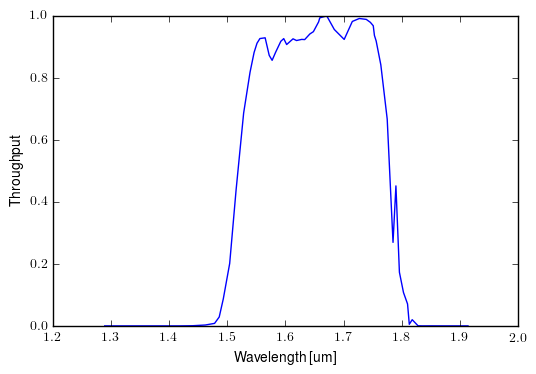

In [7]:
H_band = svo.Filter('2MASS.H')
H_band.plot()

Now we can tell `ldcfit.ldc()` to apply the filter to the spectral intensity models before calculating the limb darkening coefficients using the `bandpass` argument. We'll compare the results of using the bandpass (blue line) to the plot above where we just used the wavelength window of 1.4-1.9 $\mu m$ (green line).

Interpolating grid point [2511/5.22/0.04]...
Run time in seconds:  11.415921926498413
4-parameter :
wavelength   c1    e1    c2     e2    c3    e3    c4     e4 
---------- ----- ----- ------ ----- ----- ----- ------ -----
       1.1 1.300 0.003 -0.511 0.007 0.113 0.007 -0.002 0.003

Interpolating grid point [2511/5.22/0.04]...
Run time in seconds:  12.088258981704712
4-parameter :
wavelength   c1    e1    c2     e2    c3    e3    c4     e4 
---------- ----- ----- ------ ----- ----- ----- ------ -----
   1.63795 1.322 0.001 -0.647 0.004 0.218 0.004 -0.033 0.001



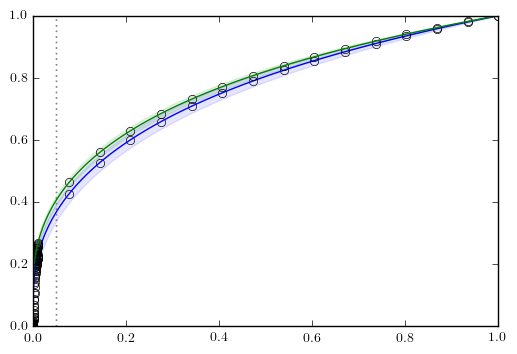

In [8]:
teff, logg, FeH = 2511, 5.22, 0.04
filt = lf.ldc(teff, logg, FeH, model_grid, ['4-parameter'], plot=plt.figure())
no_filt = lf.ldc(teff, logg, FeH, model_grid, ['4-parameter'], plot=plt.gcf(), bandpass=H_band, colors=['g'])

# Using a Grism
Grisms are also supported. We can use the whole grism wavelength range (as if it was a bandpass) or truncate the griconsider arbitrary wavelength ranges by  setting the `wl_min` and `wl_max` arguments.

Bandpass trimmed to 1.61 um - 1.65 um
1 bins of 400 pixels each.


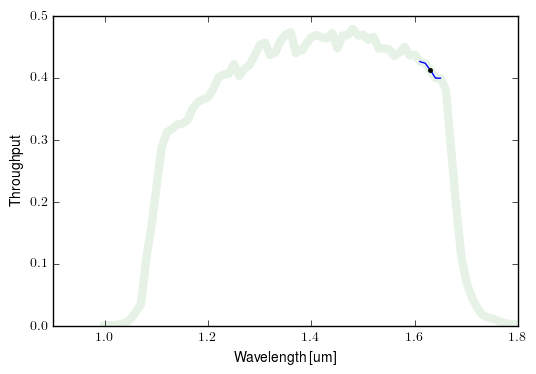

In [9]:
G141 = svo.Filter('WFC3_IR.G141', wl_min=1.61*q.um, wl_max=1.65*q.um)
G141.plot()

We can also specify the number of bins (`n_bins`) or number of channels per bin (`n_channels`) to get LDCs for each. The colors and black dots below show the bins and their centers.

Bandpass trimmed to 1.11 um - 1.65 um
15 bins of 431 pixels each.


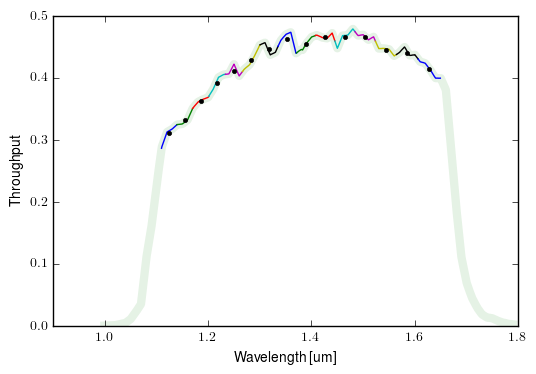

In [10]:
G141 = svo.Filter('WFC3_IR.G141', n_bins=15, wl_min=1.11*q.um, wl_max=1.65*q.um)
G141.plot()

Since we are going to use the G141 grism but previously were only interested in H-band, we must reset our model grid to include the G141 wavelength range.

In [11]:
model_grid.reset()
mn, mx = G141.WavelengthMin, G141.WavelengthMax
model_grid.customize(Teff_rng=(2500,2600), logg_rng=(5,5.5), FeH_rng=(-0.5,0.5), wave_rng=(mn,mx))

1056 models loaded from /user/jfilippazzo/Models/ACES/default/
12/1056 spectra in parameter range Teff:  (2500, 2600) , logg:  (5, 5.5) , FeH:  (-0.5, 0.5) , wavelength:  (1.04039, 1.77466)
Loading flux into table...
100.00 percent complete!


Now we can caluclate the LDCs for each wavelength bin of the G141 grism, where the first column in the table is the bin center. This is not very useful to plot but... why not?

Interpolating grid point [2511/5.22/0.04]...
Run time in seconds:  133.34923601150513
4-parameter :
wavelength   c1    e1    c2     e2    c3     e3    c4     e4 
---------- ----- ----- ------ ----- ------ ----- ------ -----
   1.12483 1.561 0.005 -0.863 0.013  0.298 0.014 -0.039 0.005
   1.15494 1.738 0.001 -1.297 0.003  0.653 0.003 -0.145 0.001
   1.18585 1.611 0.004 -1.002 0.010  0.413 0.011 -0.073 0.004
    1.2176 1.568 0.004 -0.938 0.011  0.363 0.012 -0.058 0.005
   1.25019 1.463 0.004 -0.818 0.010  0.298 0.010 -0.045 0.004
   1.28365 1.702 0.006 -1.420 0.014  0.798 0.015 -0.197 0.006
   1.31801 1.711 0.008 -1.472 0.020  0.853 0.021 -0.217 0.008
    1.3533 0.750 0.010  0.694 0.026 -0.748 0.027  0.233 0.010
   1.38952 0.672 0.013  0.944 0.033 -0.995 0.035  0.311 0.013
   1.42671 0.544 0.007  1.033 0.018 -0.930 0.019  0.267 0.007
    1.4649 0.641 0.011  0.905 0.027 -0.911 0.029  0.279 0.011
   1.50412 0.791 0.014  0.670 0.035 -0.821 0.037  0.271 0.014
   1.54438 1.067 0.015  0.113 0.

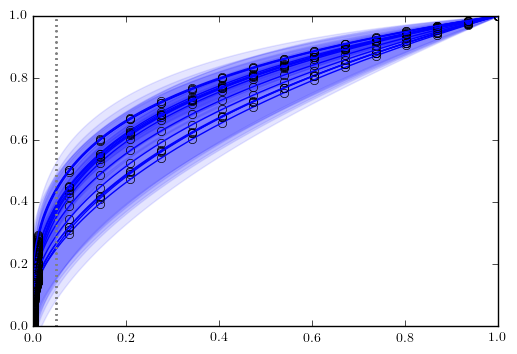

In [12]:
teff, logg, FeH = 2511, 5.22, 0.04
grism = lf.ldc(teff, logg, FeH, model_grid, ['4-parameter'], plot=plt.figure(), bandpass=G141)

Enjoy!

## Trappist-1
Here are the LDCs for Trappist-1 with a top hat filter and with the G141 grism.

In [ ]:
tophat = svo.Filter('tophat', wl_min=1.1*q.um, wl_max=1.7*q.um)
teff, logg, FeH = 2511, 5.22, 0.04
th_filt = lf.ldc(teff, logg, FeH, model_grid, ['quadratic', '4-parameter'], grid_point=trap1, bandpass=tophat, plot=plt.figure())

In [ ]:
G141 = svo.Filter('WFC3_IR.G141', wl_min=1.1*q.um, wl_max=1.7*q.um)
gr_filt = lf.ldc(teff, logg, FeH, model_grid, ['quadratic', '4-parameter'], grid_point=trap1, plot=plt.gcf(), bandpass=G141)